This code is structured as follows: First pawprint and then pawprint plus.

In [93]:
# All my imports
import os
import cv2
from copy import deepcopy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import glob
from pathlib import Path
import torch
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import shutil, time
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# Mount the Google Drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/PawPrint_Project'
# directories
os.makedirs(base_dir, exist_ok=True)
os.makedirs(os.path.join(base_dir, 'data'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'models'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'outputs'), exist_ok=True)

Mounted at /content/drive


In [4]:
# Path
# Store it in local data, to access it faster
zip_dir = '/content/drive/MyDrive/PawPrint_Project/data'
unzip_target = '/content/local_data'

# unzip
for file in os.listdir(zip_dir):
    if file.endswith('.zip'):
        zip_path = os.path.join(zip_dir, file)
        folder_name = os.path.splitext(file)[0]
        out_dir = os.path.join(unzip_target, folder_name)
        print(f"Unzip {file} → {out_dir}")
        os.makedirs(out_dir, exist_ok=True)
        !unzip -q "$zip_path" -d "$out_dir"

Unzip PawPrint_ICIP2025.zip → /content/local_data/PawPrint_ICIP2025
Unzip PawPrintplus_ICIP2025.zip → /content/local_data/PawPrintplus_ICIP2025


In [18]:
local_data_path = '/content/local_data/PawPrint_ICIP2025/PP'
data_path = local_data_path

start = time.time()
# check, if exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset folder not found at: {data_path}")

# set train/test paths
train_path = os.path.join(data_path, 'train')
test_path  = os.path.join(data_path, 'test')

print("Train path:", train_path)
print("Test path:", test_path)

Train path: /content/local_data/PawPrint_ICIP2025/PP/train
Test path: /content/local_data/PawPrint_ICIP2025/PP/test


In [19]:
# Preprocessing
# I use 224x224 because it's much faster to train,
# but (hopefully) still large enough to keep the footprint details
TARGET_SIZE = 224

# Normalization values from ImageNet
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

augment = True

def letterbox_cv2_to_tensor(path, size=TARGET_SIZE, augment=True):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Resize with padding to square
    scale = min(size / h, size / w)
    nh, nw = int(h * scale), int(w * scale)
    interp = cv2.INTER_AREA if max(h, w) < 2*size else cv2.INTER_LINEAR
    resized = cv2.resize(img, (nw, nh), interpolation=interp)
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    y0, x0 = (size - nh)//2, (size - nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = resized

    # Augmentation
    if augment:
        # 1) horizontal flip
        if np.random.rand() < 0.5:
            canvas = np.ascontiguousarray(canvas[:, ::-1, :])

        # 2) small rotation plus minus 10 degrees
        if np.random.rand() < 0.3:
            angle = np.random.uniform(-10, 10)
            M = cv2.getRotationMatrix2D((size/2, size/2), angle, 1.0)
            canvas = cv2.warpAffine(canvas, M, (size, size),
                                    flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=(0,0,0))

        # 3) slight brightness / contrast change
        if np.random.rand() < 0.3:
            alpha = np.random.uniform(0.9, 1.1)
            beta  = np.random.uniform(-10, 10)
            canvas = np.clip(alpha * canvas + beta, 0, 255).astype(np.uint8)

    # Normalize to 0-1
    canvas = canvas.astype(np.float32) / 255.0
    canvas = (canvas - IMAGENET_MEAN) / IMAGENET_STD
    return torch.from_numpy(canvas.transpose(2, 0, 1)).float()


In [20]:
# Create label map
def build_label_map(train_root):
    """
    Creates a mapping between class names, so individual animals,
    and numbers.
    """
    exts = {'.png','.jpg','.jpeg','.bmp'}
    classes = set()

    # Collect all names
    for p in Path(train_root).rglob('*'):
        if p.is_file() and p.suffix.lower() in exts:
            parts = p.parent.parts
            if len(parts) >= 2 and parts[-2].lower() in ('cat','dog'):
                cname = f"{parts[-2]}_{parts[-1]}"
            else:
                cname = parts[-1]
            classes.add(cname)

    idx_to_class = sorted(classes)
    class_to_idx = {c:i for i,c in enumerate(idx_to_class)}
    return class_to_idx, idx_to_class

class FootprintDataset(Dataset):
    """
    Custom PyTorch dataset that loads each image on demand
    """
    def __init__(self, root_dir, class_to_idx, is_train=True):
        self.root = Path(root_dir)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.samples = []

        exts = ('.png','.jpg','.jpeg','.bmp')
        files = [Path(p) for p in glob.glob(str(self.root/'**/*'), recursive=True)
                 if Path(p).suffix.lower() in exts]

        def cname_for(p: Path):
            parts = p.parent.parts
            if len(parts) >= 2 and parts[-2].lower() in ('cat','dog'):
                return f"{parts[-2]}_{parts[-1]}"
            return parts[-1]

        for p in files:
            cname = cname_for(p)
            if cname in class_to_idx:
                self.samples.append((str(p), class_to_idx[cname]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        x = letterbox_cv2_to_tensor(path, size=TARGET_SIZE, augment=self.is_train)
        return x, label, path

# Build dataset
class_to_idx, idx_to_class = build_label_map(train_path)

train_ds = FootprintDataset(train_path, class_to_idx, is_train=True)
test_ds  = FootprintDataset(test_path,  class_to_idx, is_train=False)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Classes: {len(idx_to_class)} | Train: {len(train_ds)} | Test: {len(test_ds)}")
print("Example classes:", idx_to_class[:5])


Classes: 20 | Train: 643 | Test: 290
Example classes: ['cat_cat_geomson', 'cat_cat_lilly', 'cat_cat_morae', 'cat_cat_munji', 'cat_cat_seoli']


In [21]:
# Summarize dataset structure without loading images into RAM
t0 = time.time()
print("\n" + "="*50)
print("DATA SUMMARY (paths, labels, counts)")
print("="*50)

print(f"Identities (classes): {len(idx_to_class)}")

# Count per-class samples in train/test (by label index)
def count_by_label(ds):
    labels = [y for _, y in ds.samples]  # uses paths only
    return Counter(labels)

train_counts = count_by_label(train_ds)
test_counts  = count_by_label(test_ds)

print(f"Train samples: {len(train_ds)}")
print(f"Test  samples: {len(test_ds)}\n")

for idx, name in enumerate(idx_to_class):
    tr = train_counts.get(idx, 0)
    te = test_counts.get(idx, 0)
    print(f"  {idx:3d}: {name}  (train: {tr:4d}, test: {te:4d})")

print(f"\nDone in {time.time()-t0:.2f}s")



DATA SUMMARY (paths, labels, counts)
Identities (classes): 20
Train samples: 643
Test  samples: 290

    0: cat_cat_geomson  (train:   25, test:   11)
    1: cat_cat_lilly  (train:   53, test:   24)
    2: cat_cat_morae  (train:   11, test:    5)
    3: cat_cat_munji  (train:   16, test:    8)
    4: cat_cat_seoli  (train:   86, test:   37)
    5: cat_cat_sky  (train:   11, test:    6)
    6: cat_cat_star  (train:   23, test:   11)
    7: dog_dog_angae  (train:   14, test:    7)
    8: dog_dog_bbibbi  (train:   35, test:   15)
    9: dog_dog_bori  (train:   30, test:   14)
   10: dog_dog_coco  (train:   24, test:   11)
   11: dog_dog_kong  (train:   26, test:   12)
   12: dog_dog_mi  (train:   18, test:    8)
   13: dog_dog_mina  (train:   33, test:   15)
   14: dog_dog_ming  (train:   32, test:   14)
   15: dog_dog_pony  (train:   93, test:   41)
   16: dog_dog_pori  (train:    5, test:    3)
   17: dog_dog_pp  (train:   32, test:   14)
   18: dog_dog_sol  (train:   18, test:    8)
 

In [22]:
# Create a stratified train/val split using labels from train_ds
print("\n" + "="*50)
print("STRATIFIED TRAIN/VAL SPLIT (80/20)")
print("="*50)

all_indices = list(range(len(train_ds)))
all_labels  = [train_ds.samples[i][1] for i in all_indices]

idx_tr, idx_va = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

train_split = Subset(train_ds, idx_tr)
val_split   = Subset(train_ds, idx_va)

print(f"Training set:   {len(train_split)} samples")
print(f"Validation set: {len(val_split)} samples")
print(f"Test set:       {len(test_ds)} samples")



STRATIFIED TRAIN/VAL SPLIT (80/20)
Training set:   514 samples
Validation set: 129 samples
Test set:       290 samples


In [23]:
# Build loders for the new splits
BATCH_SIZE = 32
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_split,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,     batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Batches:", len(train_loader), "(train),", len(val_loader), "(val),", len(test_loader), "(test)")


Batches: 17 (train), 5 (val), 10 (test)


[Epoch 01] train 1.5744/0.494 | val 4.3651/0.349


[Epoch 02] train 0.9815/0.654 | val 2.1790/0.519


[Epoch 03] train 0.7397/0.726 | val 1.4898/0.705


[Epoch 04] train 0.5404/0.825 | val 1.1818/0.628


[Epoch 05] train 0.4250/0.864 | val 0.8013/0.721


[Epoch 06] train 0.3700/0.874 | val 0.8137/0.736


[Epoch 07] train 0.2670/0.901 | val 0.8010/0.752


[Epoch 08] train 0.2264/0.928 | val 0.5401/0.845


[Epoch 09] train 0.1636/0.951 | val 0.3659/0.891


[Epoch 10] train 0.1404/0.963 | val 0.4565/0.853


[Epoch 11] train 0.1235/0.965 | val 0.3076/0.922


[Epoch 12] train 0.0580/0.992 | val 0.2229/0.953


[Epoch 13] train 0.0537/0.986 | val 0.2033/0.946


[Epoch 14] train 0.0495/0.990 | val 0.2223/0.946


[Epoch 15] train 0.0660/0.986 | val 0.2822/0.915

Best Val Acc: 0.9535 | Test Acc: 0.8655
                 precision    recall  f1-score   support

cat_cat_geomson      0.909     0.909     0.909        11
  cat_cat_lilly      0.821     0.958     0.885        24
  cat_cat_morae      1.000     0.200     0.333         5
  cat_cat_munji      0.667     1.000     0.800         8
  cat_cat_seoli      0.944     0.919     0.932        37
    cat_cat_sky      1.000     0.833     0.909         6
   cat_cat_star      1.000     0.909     0.952        11
  dog_dog_angae      1.000     0.714     0.833         7
 dog_dog_bbibbi      0.923     0.800     0.857        15
   dog_dog_bori      1.000     1.000     1.000        14
   dog_dog_coco      0.833     0.909     0.870        11
   dog_dog_kong      0.625     0.833     0.714        12
     dog_dog_mi      1.000     0.500     0.667         8
   dog_dog_mina      0.833     0.667     0.741        15
   dog_dog_ming      0.800     0.857     0.828        

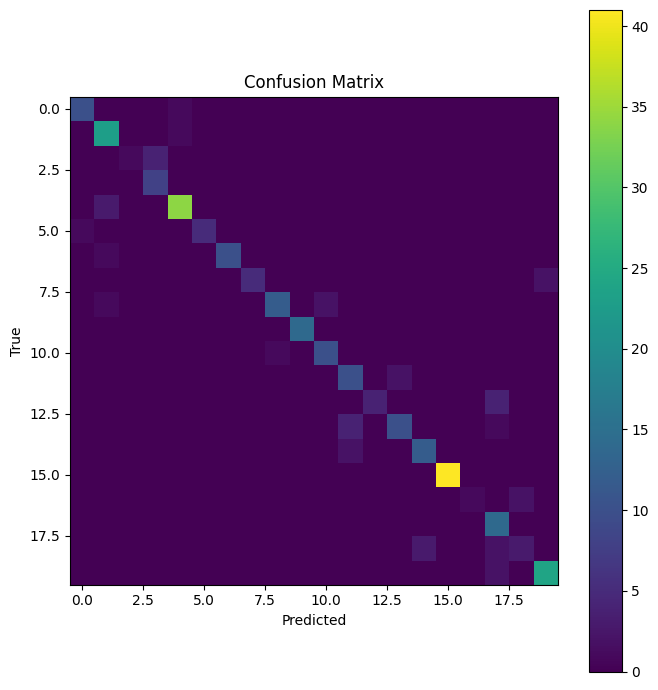

Saved: /content/local_data/resnet34_pawprints.pth


In [24]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = len(idx_to_class)

# I will use ResNet34. Just needed to replace the last layer.
def build_resnet34(num_classes=NUM_CLASSES):
    m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(DEVICE)

@torch.no_grad()
# Check model accuracy
def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    y_true, y_pred = [], []
    for x,y,_ in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        tot_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        tot_correct += (pred == y).sum().item()
        tot += x.size(0)
        y_true.extend(y.cpu().tolist()); y_pred.extend(pred.cpu().tolist())
    return tot_loss/tot, tot_correct/tot, y_true, y_pred

# Train the model
def train(model, train_loader, val_loader, epochs=8, lr=5e-4, wd=1e-4):
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    best_acc, best_state = 0.0, None
    for ep in range(1, epochs+1):
        model.train()
        run_loss, run_correct, run_total = 0.0, 0, 0
        for x,y,_ in tqdm(train_loader, leave=False):
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * x.size(0)
            run_correct += (logits.argmax(1) == y).sum().item()
            run_total += x.size(0)
        sched.step()

        tr_loss = run_loss/run_total
        tr_acc  = run_correct/run_total
        va_loss, va_acc, _, _ = evaluate(model, val_loader)
        print(f"[Epoch {ep:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        # keep best model by validation accuracy
        if va_acc > best_acc:
            best_acc = va_acc
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}

    # load best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# 2) Build & train
model = build_resnet34(NUM_CLASSES)
EPOCHS = 15
LR = 5e-4           # conservative for finetuning; stable
model, best_val_acc = train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

# 3) Test evaluation
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print(f"\nBest Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}")
print(classification_report(y_true, y_pred, target_names=idx_to_class, digits=3))

# 4) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix')
plt.colorbar(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

# 5) Save checkpoint
ckpt_path = '/content/local_data/resnet34_pawprints.pth'
torch.save({'model': model.state_dict(), 'classes': idx_to_class}, ckpt_path)
print("Saved:", ckpt_path)

In [25]:
# Add label smoothing and record history
def train_with_history(model, train_loader, val_loader, epochs=8, lr=5e-4, wd=1e-4, label_smoothing=0.05):
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}
    best_acc, best_state = 0.0, None

    for ep in range(1, epochs+1):
        # train
        model.train()
        run_loss, run_correct, run_total = 0.0, 0, 0
        for x,y,_ in tqdm(train_loader, leave=False):
            x = x.float().to(DEVICE); y = y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward(); opt.step()
            run_loss += loss.item() * x.size(0)
            run_correct += (logits.argmax(1) == y).sum().item()
            run_total += x.size(0)
        sched.step()
        tr_loss, tr_acc = run_loss/run_total, run_correct/run_total

        # validate
        va_loss, va_acc, _, _ = evaluate(model, val_loader)

        # save history
        history["tr_loss"].append(tr_loss)
        history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss)
        history["va_acc"].append(va_acc)

        print(f"[Epoch {ep:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        # keep best by val acc
        if va_acc > best_acc:
            best_acc = va_acc
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history, best_acc

# re-train
model = build_resnet34(NUM_CLASSES)
model, hist, best_val_acc = train_with_history(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)


[Epoch 01] train 1.8456/0.484 | val 1.5333/0.589


[Epoch 02] train 1.0822/0.700 | val 1.3145/0.597


[Epoch 03] train 0.9647/0.757 | val 0.9420/0.690


[Epoch 04] train 0.8223/0.813 | val 1.0164/0.713


[Epoch 05] train 0.7164/0.868 | val 0.6943/0.775


[Epoch 06] train 0.7850/0.856 | val 0.6476/0.783


[Epoch 07] train 0.6344/0.901 | val 0.7174/0.736


[Epoch 08] train 0.5709/0.936 | val 0.9638/0.744


[Epoch 09] train 0.5357/0.944 | val 0.4370/0.868


[Epoch 10] train 0.5059/0.951 | val 0.3639/0.876


[Epoch 11] train 0.4743/0.981 | val 0.3888/0.891


[Epoch 12] train 0.4357/0.988 | val 0.3631/0.876


[Epoch 13] train 0.4341/0.988 | val 0.3339/0.891


[Epoch 14] train 0.4185/0.992 | val 0.3286/0.891


[Epoch 15] train 0.4216/0.992 | val 0.2816/0.915


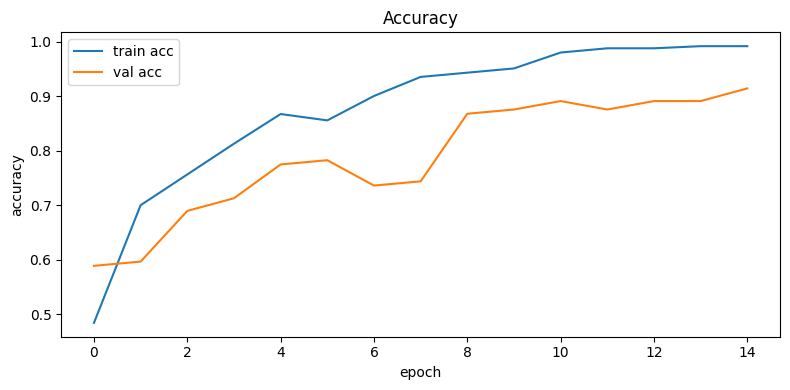

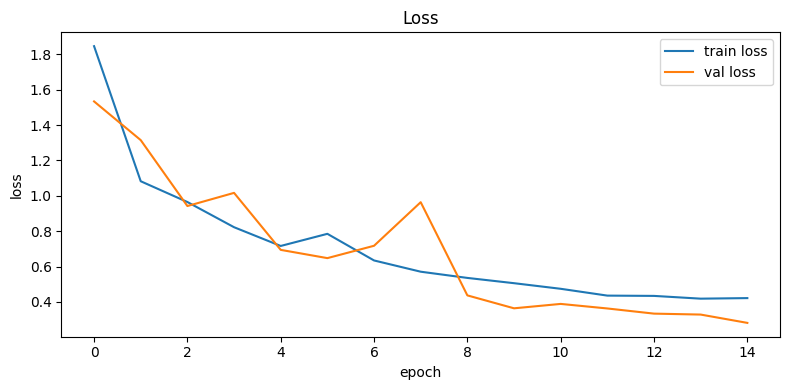

Sample predictions:
- 116_sand.png | true: dog_dog_pony | pred: dog_dog_pony
- 419_sand.png | true: dog_dog_bori | pred: dog_dog_bori
- 023_sand.png | true: dog_dog_angae | pred: cat_cat_lilly
- 012_sand.png | true: dog_dog_mina | pred: dog_dog_mina
- 084_clay.png | true: dog_dog_bbibbi | pred: dog_dog_bbibbi
- 016_sand.png | true: dog_dog_mi | pred: cat_cat_morae


In [26]:
# Learning curves and a few predictions
# learning curves
plt.figure(figsize=(8,4))
plt.plot(hist["tr_acc"], label="train acc")
plt.plot(hist["va_acc"], label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["tr_loss"], label="train loss")
plt.plot(hist["va_loss"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss"); plt.tight_layout(); plt.show()

# check on a few test images
model.eval()
to_show = []
with torch.no_grad():
    # few random indices from test_ds
    idxs = random.sample(range(len(test_ds)), k=min(6, len(test_ds)))
    for i in idxs:
        x, y_true, path = test_ds[i]
        logits = model(x.unsqueeze(0).float().to(DEVICE))
        pred = logits.argmax(1).item()
        to_show.append((path, idx_to_class[y_true], idx_to_class[pred]))

print("Sample predictions:")
for path, truth, pred in to_show:
    print(f"- {Path(path).name} | true: {truth} | pred: {pred}")


Final Test Accuracy: 0.8621
                 precision    recall  f1-score   support

cat_cat_geomson      1.000     0.909     0.952        11
  cat_cat_lilly      0.742     0.958     0.836        24
  cat_cat_morae      0.500     0.600     0.545         5
  cat_cat_munji      0.750     0.750     0.750         8
  cat_cat_seoli      0.879     0.784     0.829        37
    cat_cat_sky      1.000     0.833     0.909         6
   cat_cat_star      0.909     0.909     0.909        11
  dog_dog_angae      0.833     0.714     0.769         7
 dog_dog_bbibbi      1.000     0.867     0.929        15
   dog_dog_bori      1.000     1.000     1.000        14
   dog_dog_coco      0.846     1.000     0.917        11
   dog_dog_kong      0.625     0.833     0.714        12
     dog_dog_mi      1.000     0.500     0.667         8
   dog_dog_mina      0.833     0.667     0.741        15
   dog_dog_ming      0.917     0.786     0.846        14
   dog_dog_pony      1.000     1.000     1.000        41
  

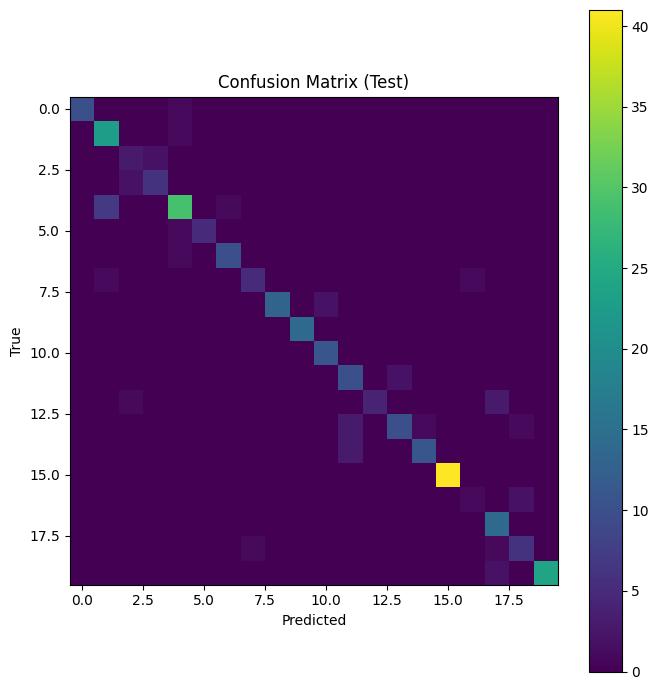

Saved: /content/local_data/figs/classification_report.txt /content/local_data/figs/confusion_matrix.png


In [27]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=idx_to_class, digits=3)
print(report)

out_dir = Path("/content/local_data/figs"); out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir/"classification_report.txt", "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(out_dir/"confusion_matrix.png", dpi=150)
plt.show()

print("Saved:",
      out_dir/"classification_report.txt",
      out_dir/"confusion_matrix.png")

PawPrintPlus. It is not good to just duplicate the code, but for this task I did it, because I was testing out a different model first for pawprint plus. That didn't give me good enough results, so I switched to ResNet34 again. The first time I used a code, that wasn't duplicated, and I only needed to switch the dataset, but it only gave me 15 % test accuracy and I couldn't fix it. I was trying to fix it for more then three hours, but I couldn't. So I just copied the code, made some slight changes and now it works.

In [83]:
local_data_path = '/content/local_data/PawPrintplus_ICIP2025/PP+'
data_path = local_data_path

start = time.time()
print("Using local dataset.")

# check if it exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset folder not found at: {data_path}")

# set train/test paths
train_path = os.path.join(data_path, 'train')
test_path  = os.path.join(data_path, 'test')

print("Train path:", train_path)
print("Test path:", test_path)

Using local dataset.
Train path: /content/local_data/PawPrintplus_ICIP2025/PP+/train
Test path: /content/local_data/PawPrintplus_ICIP2025/PP+/test


In [84]:
# Preprocessinf
# I use 384x384 because it's much faster to train
TARGET_SIZE = 284

# Normalization values from ImageNet
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def letterbox_cv2_to_tensor(path, size=TARGET_SIZE, augment=False):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Resize with padding to square
    scale = min(size / h, size / w)
    nh, nw = int(h * scale), int(w * scale)
    interp = cv2.INTER_AREA if max(h, w) < 2*size else cv2.INTER_LINEAR
    resized = cv2.resize(img, (nw, nh), interpolation=interp)
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    y0, x0 = (size - nh)//2, (size - nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = resized

    # Augmenatation
    if augment:
        # 1) random horizontal flip
        if np.random.rand() < 0.5:
            canvas = np.ascontiguousarray(canvas[:, ::-1, :])

        # 2) small rotation plus minus 12 degrees
        if np.random.rand() < 0.35:
            angle = np.random.uniform(-12, 12)
            M = cv2.getRotationMatrix2D((size/2, size/2), angle, 1.0)
            canvas = cv2.warpAffine(canvas, M, (size, size),
                                    flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=(0,0,0))

        # 3) slight brightness / contrast change
        if np.random.rand() < 0.35:
            alpha = np.random.uniform(0.85, 1.15)
            beta  = np.random.uniform(-15, 15)
            canvas = np.clip(alpha * canvas + beta, 0, 255).astype(np.uint8)
        if np.random.rand() < 0.25:
            canvas = cv2.GaussianBlur(canvas, (3,3), 0)

    # Normalize
    canvas = canvas.astype(np.float32) / 255.0
    canvas = (canvas - IMAGENET_MEAN) / IMAGENET_STD
    return torch.from_numpy(canvas.transpose(2, 0, 1)).float()


In [94]:
def _extract_identity_from_path(p: Path, allowed_species=('dog',)):
    dir_parts = p.parent.parts
    dir_parts_lc = [s.lower() for s in dir_parts]

    sp_idx = None
    for i, s in enumerate(dir_parts_lc):
        if s in allowed_species:
            sp_idx = i
            break

    if sp_idx is not None and sp_idx + 1 < len(dir_parts):
        species = dir_parts_lc[sp_idx]
        identity = dir_parts[sp_idx + 1]
        return identity if identity.lower().startswith(species) else f"{species}_{identity}"
    return None

def build_label_map(train_root, test_root=None, allowed_species=('dog',)):
    """
    Creates a consistent mapping between class names and numbers
    by scanning both train and test with the SAME PP+ extractor.
    """
    exts = {'.png', '.jpg', '.jpeg', '.bmp'}
    classes = set()

    def collect(root):
        if not root or not os.path.exists(root):
            return
        for p in Path(root).rglob('*'):
            if p.is_file() and p.suffix.lower() in exts:
                cname = _extract_identity_from_path(p, allowed_species)
                if cname:
                    classes.add(cname)

    collect(train_root)
    collect(test_root)

    if not classes:
        raise RuntimeError("No classes found. Check your PP+ paths and extractor.")

    idx_to_class = sorted(classes)
    class_to_idx = {c: i for i, c in enumerate(idx_to_class)}
    return class_to_idx, idx_to_class

class FootprintDataset(Dataset):
    """
    Custom PyTorch dataset that loads each image on demand.
    """
    def __init__(self, root_dir, class_to_idx, is_train=True):
        self.root = Path(root_dir)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.samples = []


        exts = ('.png','.jpg','.jpeg','.bmp')
        files = [Path(p) for p in glob.glob(str(self.root/'**/*'), recursive=True)
                 if Path(p).suffix.lower() in exts]

        for p in files:
          cname = _extract_identity_from_path(p, allowed_species=('dog',))
          if cname is not None and cname in class_to_idx:
            self.samples.append((str(p), class_to_idx[cname]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # Load + preprocess
        x = letterbox_cv2_to_tensor(path, size=TARGET_SIZE, augment=self.is_train)
        return x, label, path

# build datatset and loaders
class_to_idx, idx_to_class = build_label_map(train_root=train_path, test_root=test_path)


train_ds = FootprintDataset(train_path, class_to_idx, is_train=True)
test_ds  = FootprintDataset(test_path,  class_to_idx, is_train=False)
all_files = train_ds.samples + test_ds.samples
all_paths = [p for p, _ in all_files]
all_labels = [y for _, y in all_files]

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=43)

# first split train+val vs test
idx_trainval, idx_test = next(sss1.split(all_paths, all_labels))
# then train vs val within trainval
paths_trainval = [all_paths[i] for i in idx_trainval]
labels_trainval = [all_labels[i] for i in idx_trainval]
idx_train, idx_val = next(sss2.split(paths_trainval, labels_trainval))

idx_train = np.array(idx_train).tolist()
idx_val   = np.array(idx_val).tolist()
idx_test  = np.array(idx_test).tolist()

# build sample tuples (path, label)
train_samples = [(paths_trainval[i], labels_trainval[i]) for i in idx_train]
val_samples   = [(paths_trainval[i], labels_trainval[i]) for i in idx_val]
test_samples  = [(all_paths[i],      all_labels[i])      for i in idx_test]

print(f"[SSS] Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")

# clone dataset shells
train_ds_split = deepcopy(train_ds); train_ds_split.samples = train_samples;  train_ds_split.is_train = True
val_ds_split   = deepcopy(train_ds); val_ds_split.samples   = val_samples;    val_ds_split.is_train   = False
test_ds_split  = deepcopy(train_ds); test_ds_split.samples  = test_samples;   test_ds_split.is_train  = False

BATCH_SIZE = 16
train_loader = DataLoader(train_ds_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds_split,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds_split,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Classes: {len(idx_to_class)} | Train: {len(train_ds)} | Test: {len(test_ds)}")
print("Example classes:", idx_to_class[:5])



[SSS] Train: 1200, Val: 212, Test: 250
Classes: 12 | Train: 580 | Test: 1082
Example classes: ['dog_angae', 'dog_bbibbi', 'dog_bori', 'dog_coco', 'dog_kong']


In [95]:
# Summarize dataset structure without loading images into RAM
t0 = time.time()
print("\n" + "="*50)
print("DATA SUMMARY (paths, labels, counts)")
print("="*50)

print(f"Identities (classes): {len(idx_to_class)}")

# Count per-class samples in train/test
def count_by_label(ds):
    labels = [y for _, y in ds.samples]
    return Counter(labels)

train_counts = count_by_label(train_ds)
test_counts  = count_by_label(test_ds)

print(f"Train samples: {len(train_ds)}")
print(f"Test  samples: {len(test_ds)}\n")

for idx, name in enumerate(idx_to_class):
    tr = train_counts.get(idx, 0)
    te = test_counts.get(idx, 0)
    print(f"  {idx:3d}: {name}  (train: {tr:4d}, test: {te:4d})")

print(f"\nDone in {time.time()-t0:.2f}s")



DATA SUMMARY (paths, labels, counts)
Identities (classes): 12
Train samples: 580
Test  samples: 1082

    0: dog_angae  (train:   21, test:   63)
    1: dog_bbibbi  (train:   50, test:   68)
    2: dog_bori  (train:   44, test:  416)
    3: dog_coco  (train:   35, test:   66)
    4: dog_kong  (train:   38, test:   56)
    5: dog_mi  (train:   26, test:   34)
    6: dog_mina  (train:   48, test:   58)
    7: dog_ming  (train:   46, test:   74)
    8: dog_pony  (train:  134, test:   46)
    9: dog_pori  (train:    8, test:    5)
   10: dog_pp  (train:   46, test:   76)
   11: dog_wangbal  (train:   84, test:  120)

Done in 0.00s


In [98]:
# Create a stratified train/val split using labels from train_ds
train_samples = [(paths_trainval[i], labels_trainval[i]) for i in idx_train]
val_samples   = [(paths_trainval[i], labels_trainval[i]) for i in idx_val]
test_samples  = [(all_paths[i],      all_labels[i])      for i in idx_test]

print(f"[SSS] Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")

# clone dataset
train_ds_split = deepcopy(train_ds); train_ds_split.samples = train_samples;  train_ds_split.is_train = True
val_ds_split   = deepcopy(train_ds); val_ds_split.samples   = val_samples;    val_ds_split.is_train   = False
test_ds_split  = deepcopy(train_ds); test_ds_split.samples  = test_samples;   test_ds_split.is_train  = False



[SSS] Train: 1200, Val: 212, Test: 250


In [99]:
# Build loaders for the new splits
BATCH_SIZE = 16

train_loader = DataLoader(train_ds_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds_split,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds_split,     batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Batches:", len(train_loader), "(train),", len(val_loader), "(val),", len(test_loader), "(test)")


Batches: 75 (train), 14 (val), 16 (test)


[Epoch 01] train 1.4908/0.493 | val 1.0233/0.575


[Epoch 02] train 1.1346/0.581 | val 1.3262/0.542


[Epoch 03] train 1.0353/0.615 | val 0.9322/0.665


[Epoch 04] train 0.9110/0.644 | val 0.7254/0.689


[Epoch 05] train 0.7625/0.707 | val 0.6340/0.755


[Epoch 06] train 0.6424/0.747 | val 0.7111/0.703


[Epoch 07] train 0.5957/0.776 | val 0.5558/0.769


[Epoch 08] train 0.5047/0.811 | val 0.5333/0.797


[Epoch 09] train 0.4270/0.834 | val 0.3732/0.844


[Epoch 10] train 0.3353/0.877 | val 0.4294/0.802


[Epoch 11] train 0.2711/0.909 | val 0.4616/0.854


[Epoch 12] train 0.2288/0.916 | val 0.3232/0.896


[Epoch 13] train 0.1927/0.927 | val 0.2744/0.896


[Epoch 14] train 0.1736/0.942 | val 0.2526/0.906


[Epoch 15] train 0.1510/0.952 | val 0.2475/0.901

Best Val Acc: 0.9057 | Test Acc: 0.9040
              precision    recall  f1-score   support

   dog_angae      1.000     0.923     0.960        13
  dog_bbibbi      0.833     0.833     0.833        18
    dog_bori      0.972     1.000     0.986        69
    dog_coco      0.800     0.800     0.800        15
    dog_kong      0.667     0.714     0.690        14
      dog_mi      0.875     0.778     0.824         9
    dog_mina      0.917     0.688     0.786        16
    dog_ming      0.750     0.833     0.789        18
    dog_pony      1.000     1.000     1.000        27
    dog_pori      0.667     1.000     0.800         2
      dog_pp      0.850     0.944     0.895        18
 dog_wangbal      1.000     0.935     0.967        31

    accuracy                          0.904       250
   macro avg      0.861     0.871     0.861       250
weighted avg      0.908     0.904     0.904       250



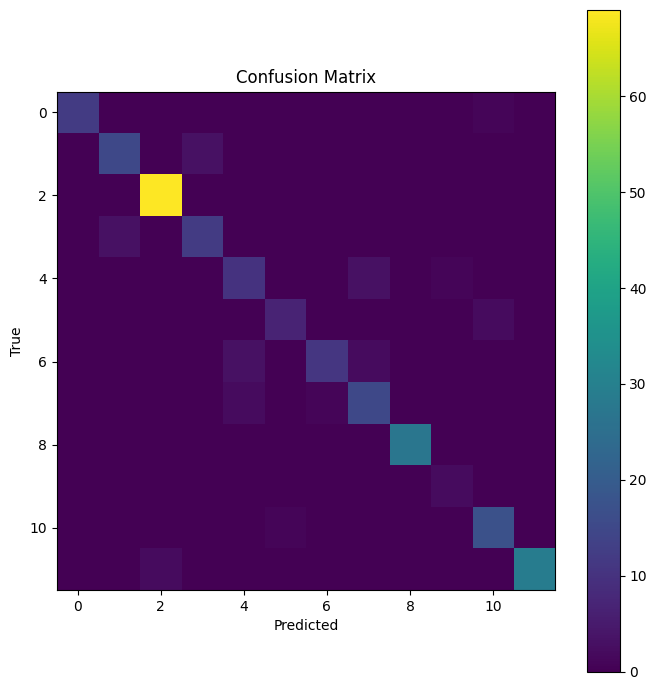

Saved: /content/local_data/resnet34_pawprintsplus.pth


In [100]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = len(idx_to_class)

# AGain I use ResNet34
def build_resnet34(num_classes=NUM_CLASSES):
    m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(DEVICE)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    y_true, y_pred = [], []
    for x,y,_ in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        tot_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        tot_correct += (pred == y).sum().item()
        tot += x.size(0)
        y_true.extend(y.cpu().tolist()); y_pred.extend(pred.cpu().tolist())
    return tot_loss/tot, tot_correct/tot, y_true, y_pred

def train(model, train_loader, val_loader, epochs=8, lr=5e-4, wd=1e-4):
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    best_acc, best_state = 0.0, None
    for ep in range(1, epochs+1):
        model.train()
        run_loss, run_correct, run_total = 0.0, 0, 0
        for x,y,_ in tqdm(train_loader, leave=False):
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * x.size(0)
            run_correct += (logits.argmax(1) == y).sum().item()
            run_total += x.size(0)
        sched.step()

        tr_loss = run_loss/run_total
        tr_acc  = run_correct/run_total
        va_loss, va_acc, _, _ = evaluate(model, val_loader)
        print(f"[Epoch {ep:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        # keep best model by validation accuracy (simple early select)
        if va_acc > best_acc:
            best_acc = va_acc
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}

    # load best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_acc

# 2) Build & train
model = build_resnet34(NUM_CLASSES)
EPOCHS = 15
LR = 5e-4
model, best_val_acc = train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

# 3) Test evaluation
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print(f"\nBest Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}")
print(classification_report(y_true, y_pred, target_names=idx_to_class, digits=3))

# 4) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix')
plt.colorbar(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

# 5) Save checkpoint
ckpt_path = '/content/local_data/resnet34_pawprintsplus.pth'
torch.save({'model': model.state_dict(), 'classes': idx_to_class}, ckpt_path)
print("Saved:", ckpt_path)

In [101]:
# Add label smoothing and record history
def train_with_history(model, train_loader, val_loader, epochs=8, lr=5e-4, wd=1e-4, label_smoothing=0.05):
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}
    best_acc, best_state = 0.0, None

    for ep in range(1, epochs+1):
        # train
        model.train()
        run_loss, run_correct, run_total = 0.0, 0, 0
        for x,y,_ in tqdm(train_loader, leave=False):
            x = x.float().to(DEVICE); y = y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward(); opt.step()
            run_loss += loss.item() * x.size(0)
            run_correct += (logits.argmax(1) == y).sum().item()
            run_total += x.size(0)
        sched.step()
        tr_loss, tr_acc = run_loss/run_total, run_correct/run_total

        # validate
        va_loss, va_acc, _, _ = evaluate(model, val_loader)

        # save history
        history["tr_loss"].append(tr_loss)
        history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss)
        history["va_acc"].append(va_acc)

        print(f"[Epoch {ep:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        # keep best by val acc
        if va_acc > best_acc:
            best_acc = va_acc
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history, best_acc

# re-train
model = build_resnet34(NUM_CLASSES)
model, hist, best_val_acc = train_with_history(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)


[Epoch 01] train 1.6257/0.467 | val 1.0866/0.571


[Epoch 02] train 1.2651/0.569 | val 0.9341/0.656


[Epoch 03] train 1.1282/0.662 | val 1.0077/0.608


[Epoch 04] train 1.0584/0.667 | val 1.3222/0.613


[Epoch 05] train 0.9855/0.693 | val 1.1089/0.599


[Epoch 06] train 0.8754/0.756 | val 0.6176/0.745


[Epoch 07] train 0.8409/0.779 | val 0.5366/0.811


[Epoch 08] train 0.7673/0.811 | val 0.5372/0.807


[Epoch 09] train 0.6469/0.862 | val 0.5314/0.830


[Epoch 10] train 0.6170/0.885 | val 0.4154/0.863


[Epoch 11] train 0.5639/0.908 | val 0.3784/0.882


[Epoch 12] train 0.4992/0.937 | val 0.3077/0.906


[Epoch 13] train 0.4595/0.954 | val 0.3234/0.901


[Epoch 14] train 0.4391/0.966 | val 0.2861/0.910


[Epoch 15] train 0.4171/0.981 | val 0.2869/0.910


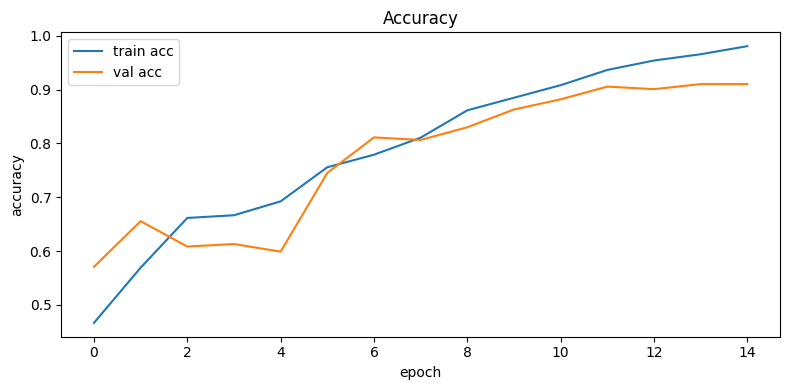

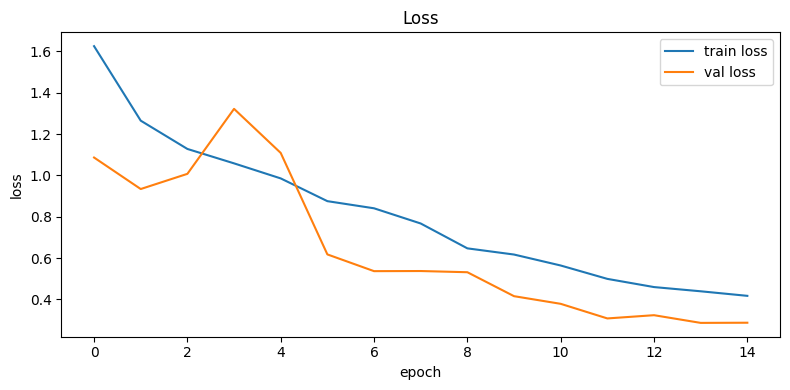

Sample predictions:
- 131_wood.png | true: dog_bori | pred: dog_bori
- 049_wood.png | true: dog_bori | pred: dog_bori
- 068_wood.png | true: dog_coco | pred: dog_coco
- 125_wood.png | true: dog_wangbal | pred: dog_wangbal
- 070_wood.png | true: dog_kong | pred: dog_kong
- 044_wood.png | true: dog_bbibbi | pred: dog_bbibbi


In [102]:
# learning curves, a few predictions
# learning curves
plt.figure(figsize=(8,4))
plt.plot(hist["tr_acc"], label="train acc")
plt.plot(hist["va_acc"], label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["tr_loss"], label="train loss")
plt.plot(hist["va_loss"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss"); plt.tight_layout(); plt.show()

# check on a few test images
model.eval()
to_show = []
with torch.no_grad():
    # few random indices from test_ds
    idxs = random.sample(range(len(test_ds)), k=min(6, len(test_ds)))
    for i in idxs:
        x, y_true, path = test_ds[i]
        logits = model(x.unsqueeze(0).float().to(DEVICE))
        pred = logits.argmax(1).item()
        to_show.append((path, idx_to_class[y_true], idx_to_class[pred]))

print("Sample predictions:")
for path, truth, pred in to_show:
    print(f"- {Path(path).name} | true: {truth} | pred: {pred}")


Final Test Accuracy: 0.9360
              precision    recall  f1-score   support

   dog_angae      1.000     1.000     1.000        13
  dog_bbibbi      0.900     1.000     0.947        18
    dog_bori      0.958     1.000     0.979        69
    dog_coco      1.000     0.867     0.929        15
    dog_kong      0.857     0.857     0.857        14
      dog_mi      0.875     0.778     0.824         9
    dog_mina      0.812     0.812     0.812        16
    dog_ming      0.833     0.833     0.833        18
    dog_pony      1.000     0.963     0.981        27
    dog_pori      1.000     1.000     1.000         2
      dog_pp      0.895     0.944     0.919        18
 dog_wangbal      1.000     0.935     0.967        31

    accuracy                          0.936       250
   macro avg      0.928     0.916     0.921       250
weighted avg      0.937     0.936     0.936       250



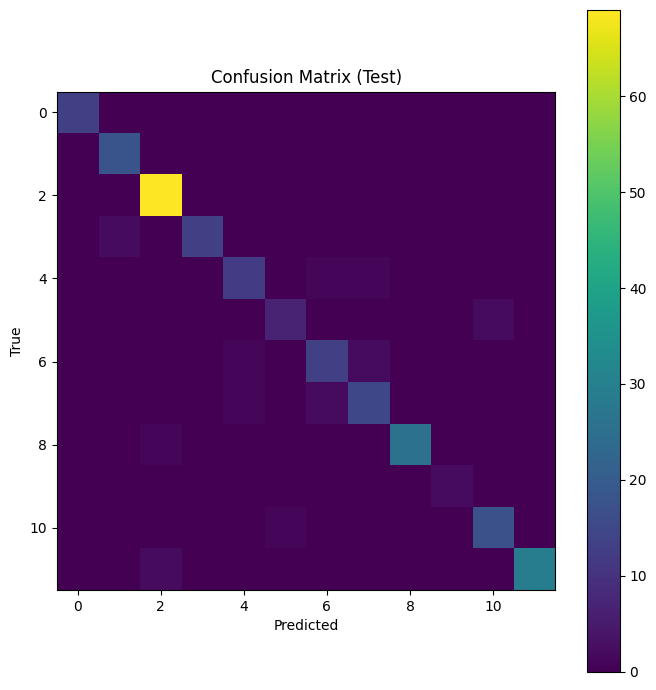

Saved: /content/local_data/figs/classification_report.txt /content/local_data/figs/confusion_matrix.png


In [103]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=idx_to_class, digits=3)
print(report)

out_dir = Path("/content/local_data/figs"); out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir/"classification_report.txt", "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(out_dir/"confusion_matrix.png", dpi=150)
plt.show()

print("Saved:",
      out_dir/"classification_report.txt",
      out_dir/"confusion_matrix.png")